In [1]:
import os
import numpy as np
import keras
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
#from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.nasnet import NASNetMobile
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
from keras.optimizers import RMSprop
import functools
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop,Adam
from keras.callbacks import LearningRateScheduler
import math

In [2]:
MODEL_NAME = "M_CNN_M1_10_20.h5"
IMG_ROWS, IMG_COLS = 224, 224
INPUT_SHAPE=(224, 224, 3)
PATH = 'data/'
TRAIN_DATA_PATH = os.path.join(PATH, 'Training')
TEST_DATA_PATH = os.path.join(PATH, 'Testing')
BATCH_SIZE = 40
NUM_EPOCHS = 100
CLASS_MODE = 'categorical'
COLOR_MODE = 'rgb'
SAVE_FORMAT = 'png'


In [3]:

data_dir_list =np.sort(os.listdir(TRAIN_DATA_PATH))
data_dir_list

array(['.DS_Store', 'glioma_tumor', 'meningioma_tumor', 'no_tumor',
       'pituitary_tumor'], dtype='<U16')

In [4]:

data_dir_list_Test =np.sort(os.listdir(TEST_DATA_PATH))
data_dir_list_Test

array(['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'],
      dtype='<U16')

In [5]:
train_data_gen = ImageDataGenerator(
    rotation_range=20,
    brightness_range=[0.6, 0.9],
    zoom_range=[0.5,1.5],
    rescale=1./255,
    vertical_flip=True, 
    validation_split=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True) 

In [6]:
train_generator = train_data_gen.flow_from_directory(
        TRAIN_DATA_PATH,
        target_size=(IMG_ROWS, IMG_COLS), 
        batch_size=BATCH_SIZE,
        class_mode=CLASS_MODE,
        color_mode=COLOR_MODE, 
        shuffle=True,   
        save_format=SAVE_FORMAT, 
        subset="training")


val_generator = train_data_gen.flow_from_directory(
    TRAIN_DATA_PATH,
    target_size=(IMG_ROWS, IMG_COLS), 
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode=COLOR_MODE, 
    shuffle=True,   
    save_format=SAVE_FORMAT, 
    subset='validation'
)

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [7]:
train_generator.samples 

2297

In [8]:
train_generator.class_indices

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [9]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_directory(
    TEST_DATA_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode=COLOR_MODE, 
    shuffle = False,
    seed=None,  
    save_format=SAVE_FORMAT
)


Found 394 images belonging to 4 classes.


In [10]:

def create_nasnet_model():
    
    # Base model, with weights pre-trained on ImageNet.
    base_model = NASNetMobile(INPUT_SHAPE, weights='imagenet', include_top=False)

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    
    learning_rate = 0.1
    momentum = 0.8
    optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=momentum, nesterov=False)

    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = optimizer,
        metrics = ['accuracy']
    )
    
    return model

In [11]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [12]:
def step_decay(epoch):
   initial_lrate = 0.1
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate

lr_scheduler =keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [13]:

callbacks_list  = [lr_scheduler]

In [14]:
import numpy as np
import math

# labels_dict : {ind_label: count_label}
# mu : parameter to tune 

def create_class_weight(labels_dict,mu=0.15):
    total = sum(labels_dict.values())
    keys = labels_dict.keys()
    class_weight = dict()
    for key in keys:
        score = (mu*total)/float(labels_dict[key])
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight

# random labels_dict
labels_dict = {0: 826, 1: 822, 2: 395, 3: 827}

class_wt = create_class_weight(labels_dict)

In [15]:
model = create_nasnet_model()

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=NUM_EPOCHS,
    workers=6,
    max_queue_size=100,
    verbose=True,
    callbacks=callbacks_list,
    #class_weight = class_wt
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/100
36/36 [==============================] - 98s 3s/step - loss: 3.1123 - accuracy: 0.4763 - val_loss: 1.7293 - val_accuracy: 0.5079

Epoch 00002: LearningRateScheduler reducing learning rate to 0.1.
Epoch 2/100
36/36 [==============================] - 95s 3s/step - loss: 1.9062 - accuracy: 0.5825 - val_loss: 1.2432 - val_accuracy: 0.6003

Epoch 00003: LearningRateScheduler reducing learning rate to 0.1.
Epoch 3/100
36/36 [==============================] - 95s 3s/step - loss: 2.0090 - accuracy: 0.5816 - val_loss: 1.9909 - val_accuracy: 0.5236

Epoch 00004: LearningRateScheduler reducing learning rate to 0.1.
Epoch 4/100
36/36 [==============================] - 95s 3s/step - loss: 2.0124 - accuracy: 0.5825 - val_loss: 1.5188 - val_accuracy: 0.6108

Epoch 00005: LearningRateScheduler reducing learning rate to 0.1.
Epoch 5/100
36/36 [==============================] - 96s 3s/step - loss: 2.2965 - accuracy: 0.5777 - 


Epoch 00040: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 40/100
36/36 [==============================] - 98s 3s/step - loss: 0.7730 - accuracy: 0.7079 - val_loss: 0.7743 - val_accuracy: 0.6806

Epoch 00041: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 41/100
36/36 [==============================] - 98s 3s/step - loss: 0.7400 - accuracy: 0.7088 - val_loss: 0.7163 - val_accuracy: 0.7225

Epoch 00042: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 42/100
36/36 [==============================] - 99s 3s/step - loss: 0.7470 - accuracy: 0.7162 - val_loss: 0.6929 - val_accuracy: 0.7208

Epoch 00043: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 43/100
36/36 [==============================] - 99s 3s/step - loss: 0.7478 - accuracy: 0.7162 - val_loss: 0.7569 - val_accuracy: 0.6824

Epoch 00044: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 44/100
36/36 [==============================] - 100s 3s/step - loss: 0.

36/36 [==============================] - 116s 3s/step - loss: 0.6912 - accuracy: 0.7340 - val_loss: 0.7334 - val_accuracy: 0.6859

Epoch 00079: LearningRateScheduler reducing learning rate to 0.00078125.
Epoch 79/100
36/36 [==============================] - 109s 3s/step - loss: 0.7267 - accuracy: 0.7127 - val_loss: 0.7098 - val_accuracy: 0.6928

Epoch 00080: LearningRateScheduler reducing learning rate to 0.000390625.
Epoch 80/100
36/36 [==============================] - 115s 3s/step - loss: 0.6955 - accuracy: 0.7266 - val_loss: 0.7169 - val_accuracy: 0.7033

Epoch 00081: LearningRateScheduler reducing learning rate to 0.000390625.
Epoch 81/100
36/36 [==============================] - 106s 3s/step - loss: 0.7022 - accuracy: 0.7270 - val_loss: 0.6952 - val_accuracy: 0.7190

Epoch 00082: LearningRateScheduler reducing learning rate to 0.000390625.
Epoch 82/100
36/36 [==============================] - 111s 3s/step - loss: 0.7027 - accuracy: 0.7179 - val_loss: 0.6699 - val_accuracy: 0.7260

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1056)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1056)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 4228      
Total params: 4,273,944
Trainable params: 4,228
Non-trainable params: 4,269,716
_________________________________________________________________


In [17]:
loss, accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {accuracy * 100}%")

7/7 [==============================] - 18s 3s/step - loss: 1.2002 - accuracy: 0.5533
Test Accuracy: 55.32994866371155%


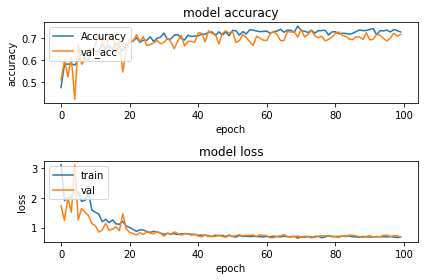

In [18]:

plt.figure(1)

# summarize history for accuracy
plt.subplot(211) 
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'val_acc'], loc='upper left')

# summarize history for loss
plt.subplot(212) 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout() 
plt.savefig('acc_loss_50.pdf')
plt.show()